# Marine Heat Wave analysis
The purpose of this notebook is to take in SST data, along with previously computed climatology and threshold, process these and output any MHW events that occur in the data

First, we import the data and required modules. 

In [1]:
import xarray as xr
import pandas as pd
import now
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
import scipy.ndimage as ndimage
import time
from cartopy import config
import cartopy.crs as ccrs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = [10,5]
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.5/23867/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Opens Climatology and MHW SST threshold files, that have been created before.
# Note: p stands for past, f for future
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pThresh = xr.open_dataarray(localDir + 'pastThreshRep.nc')
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fThresh = xr.open_dataarray(localDir + 'futureThreshRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [4]:
# Opens NOW SST data, from which we need the SST.
cfg = 'present_vs_future.ini'
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos'] #tos means sst
# SST contains both future and past run. We now split that up.
sstPast = sst.sel(simulation = 'Present')
sstFut = sst.sel(simulation = 'Future')

In [280]:
# NOW data is daily, and runs from 1990/01/01T12:00:00 to 2008/12/31T12:00:00. We use this to create our t vector.
#Two lines below taken from example_synthetic file in MHW github
t = np.arange(date(1990,1,1).toordinal(),date(2008,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

## Looking for MHW
The method we will be using to identify MHW is to:
* Create a mask on top of the data, which has a binary True/False representing whether the sst at the location is above the corressponding threshold. 
    * Using the mask, try and find consecutive days where the threshold is crossed, as these represent the MHW.
* Once we have all the SSTs that cross the threshold, we will the apply the duration requirement, and look for SSTs that cross the threshold for 5 consecutive days

### Creating a Mask (Crossing the threshold)
We are looking for SST to cross the threshold. We will do this by:
* Subtracting the background climatology from both the threshold and sst, giving us theshold anomaly (thresha) and SST anomaly (ssta).
* Dividing ssta by thresha.
* Saving the severity data, so we can simply call it for use in the animation section.
This process will not only give us a matrix of threshold crosses (as ssta > thresha at this points, ssta/thresa > 1), but also tell us about the severity of the MHW, as temperatures 2 thresholds away from the background will be represented with a two in the matrix and so on.

##### Note: Current looking at Future SSTs compared to a future Clim. The threshold is created by calculating the difference between the past percentile threshold and climatology & then adding that to the future Clim (done elsewhere).

In [10]:
%%time
# Finding thresha and ssta
thresha = fThresh.chunk({'x':50, 'y':50, 'time_counter':365}) - fClim.chunk({'x':50, 'y':50, 'time_counter':365})
ssta = sstFut.chunk({'x':50, 'y':50, 'time_counter':365}) - fClim.chunk({'x':50, 'y':50, 'time_counter':365})

CPU times: user 2.98 s, sys: 772 ms, total: 3.75 s
Wall time: 3.23 s


In [11]:
%%time
mhws = xr.where(ssta > thresha, ssta/thresha, 0)

# The next line removes any points that were made very large due to epsilon error in the ssta/thresha div
mhws = xr.where(mhws > 10, 0, mhws)

mhws['nav_lon'] = mhws['nav_lon'] % 360 

CPU times: user 3.37 s, sys: 678 ms, total: 4.05 s
Wall time: 3.64 s


In [12]:
# Saving the severity data. This is only the halfway point in the process - with duration still to go.
mhws.chunk({'x': 431, 'y':289, 'time_counter':6940}).to_netcdf("/g/data1a/e14/rm6294/NOWMHW/severityMHWNOW_futRun.nc")

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


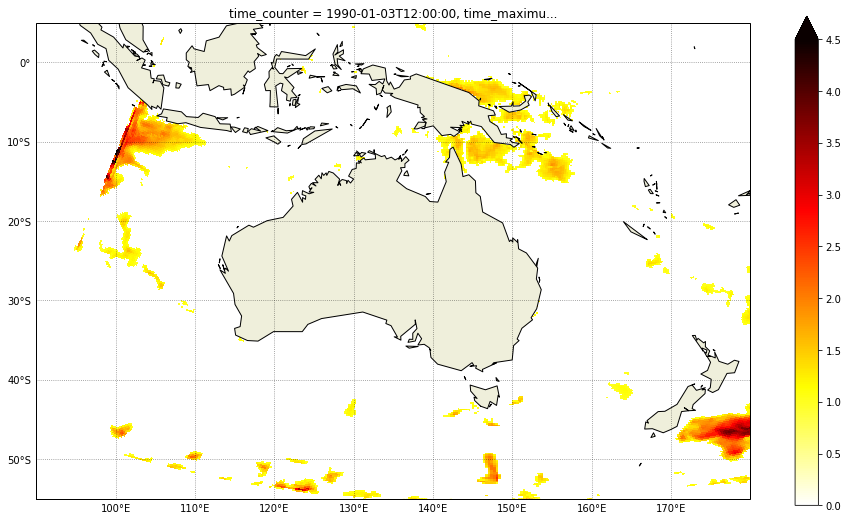

In [7]:
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 5)
mhws.isel(time_counter = 2).plot(x='nav_lon', y='nav_lat', cmap = 'hot_r',vmin = 0, vmax = 4.5, ax = ax);
#plt.savefig("/g/data1a/e14/rm6294/NOWMHW/MHWPlots/" + 'mhwPlot_{:0>3d}.png'.format(i),bbox_inches='tight')

## Checking for duration
We now have all the SSTs that cross our threshold. This section will aim to find the events that meet the 5 consecutive days with at most a 2 day gap criterion. To do this we will:
* For each time series, track how long each MHW occurs for.
* Eliminate those that are less than 5 days long 

In [21]:
# Starting with looking at future MHWs
# We are starting with the saved mhw files, which have been saved after the above mask and comparison procedure was 
# executed
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
mhws = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc')

In [22]:
mhws = mhws.chunk({'x': 50, 'y': 50})

In [23]:
mhws

<xarray.DataArray (time_counter: 6940, y: 289, x: 431)>
dask.array<shape=(6940, 289, 431), dtype=float64, chunksize=(6940, 50, 50)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 431), chunksize=(50, 50)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 431), chunksize=(50, 50)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(6940,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(6940,)>
    simulation       |S7 ...
Dimensions without coordinates: y, x

# Trials

#### Here, we try and try a solution to implement the duration definiton for MHWs. 
We will use a subset of the dataset to do this. Our approach will consider the time series at each grid point and calculate the duration for of consecutive MHW events. If the duration is less than 5 days, we will set it to zero.

In [78]:
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
mhws = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc')
# Creating subset
mhwSub = mhws.isel(x = slice(220,270),y = slice(50,100))

In [79]:
mhwSub.chunk({'x': 10, 'y': 10, 'time_counter': 1})

<xarray.DataArray (time_counter: 6940, y: 50, x: 50)>
dask.array<shape=(6940, 50, 50), dtype=float64, chunksize=(1, 10, 10)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(50, 50), chunksize=(10, 10)>
    nav_lon          (y, x) float32 dask.array<shape=(50, 50), chunksize=(10, 10)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(1,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(1,)>
    simulation       |S7 ...
Dimensions without coordinates: y, x

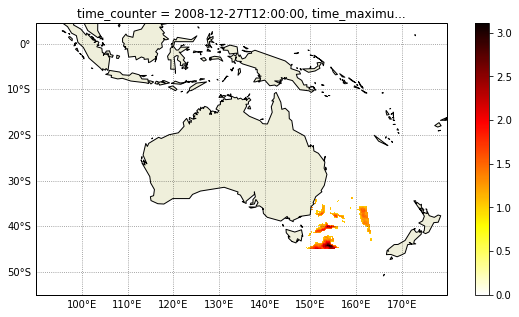

In [5]:
# Plot shows approximately what area we are considering.
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 4.5)
mhwSub.isel(time_counter = 6935).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax);

#### Date approach

In [6]:
def day2ns(days):
    # Converts days to nanoseconds. Number comes from 24 * 60 * 60 * 1e9
    return days * 86400000000000.0

In [9]:
%%time
struc = np.zeros((3,3,3))
# Just looking for consecutive SST threshold crosses in the time dimension:
struc[:,1,1] = 1
labeled_array, num_features = ndimage.label(mhwSub.data, structure = struc)

CPU times: user 231 ms, sys: 19 ms, total: 250 ms
Wall time: 227 ms


In [10]:
# Converting from date-time to nanoseconds
mhw_dates = pd.to_numeric(mhwSub['time_counter'])

In [11]:
# Creates mhw_dur object which has a time series at each grid point
mhw_dur = xr.broadcast(mhwSub, mhw_dates)[1]

In [12]:
# Removes all points in mhw_dur where SST didn't cross threshold.
mhw_dur = xr.where(labeled_array > 0, mhw_dur, 0) 

In [13]:
# Calculates the max and min time points for all labeled points
indexs = np.arange(1, num_features + 1)
maxMHW = ndimage.maximum(mhw_dur, labels=labeled_array, index=indexs)
minMHW = ndimage.minimum(mhw_dur, labels=labeled_array, index=indexs)

In [14]:
# Calculates the length of all potential MHW events.
dur = maxMHW - minMHW + day2ns(1) 

In [15]:
# converting minDur (default = 5) days to nanoseconds
minDur = int(day2ns(5)) 
# Finds the event numbers of MHWs with duration >= minDur. 
failed_ev_num = np.where(dur < minDur)[0]  + 1 # Adding 1 so that event number matches with value in labeled_array. 

In [151]:
# objs has the location of each labeled event 
#i.e objs[0] is the location of the event 1, objs[10] location of event 11  
objs = ndimage.find_objects(labeled_array)

In [185]:
# failed_objs has the location for all the failed events in labeled_array 
failed_objs = [objs[i - 1] for i in failed_ev_num]

In [213]:
for x in failed_objs:
    labeled_array[x] = 0

In [214]:
lbl = xr.full_like(mhwSub, labeled_array)
lbl = lbl.chunk({'x' : 50,'y'  :50})

In [215]:
mhw_preGap = xr.where(lbl > 0, mhwSub, 0)

In [211]:
len(failed_objs)

161455

In [206]:
copy = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc').isel(x = slice(220,270),y = slice(50,100))
copy = copy.chunk({'x': 10, 'y': 10})

In [216]:
# Check to see if something has actually changed
(mhw_preGap != copy).sum().compute()

<xarray.DataArray ()>
array(294997)
Coordinates:
    simulation  |S7 b'Future'

In [29]:
mhw_events = np.where(dur > minDur)[0]  + 1 # Adding 1 so that event number matches with value in loc. 

In [31]:
mhw_events[0:20]

array([ 31, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 190,
       404, 624, 625, 626, 627, 628, 629])

#### Now need to calculate gaps

In [117]:
# Shows the maximum and minimum date for the <index> MHW 
index = 30
print(pd.to_datetime(minMHW[index], unit = 'ns'), pd.to_datetime(maxMHW[index], unit = 'ns'), pd.to_timedelta(dur[index]))

1990-01-01 12:00:00 1990-01-07 12:00:00 7 days 00:00:00


In [348]:
mhwSub.isel(x = 7, y = 12, time_counter = slice(0,10)).data

array([0.        , 1.26158821, 1.37826623, 1.02844123, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [338]:
# Shows the time-series around the MHW event calculated above.
labeled_array[0:10, 12, 7]

array([  0, 173, 173, 173,   0,   0,   0,   0,   0,   0], dtype=int32)

In [193]:
#pd.to_datetime(maxs, unit = 'ns')

#### Cobbled Together

In [194]:
def whereIs(array, ev_num):
    # Finds location of event <ev_num> in array
    return np.where(array == ev_num)[0]

In [195]:
def clear(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array

In [12]:
def duration(array, num_events):
    # Takes in a time-series and implements the 5 day requirement for it.
    min_duration = 5
    for ev in range(1, num_events + 1):
        loc = whereIs(array, ev)
        if len(loc) < min_duration:
            array = clear(array, loc)
    return array

In [64]:
struc = np.zeros((3,3,3))
struc[:,1,1] = 1
labeled_array1, num_features1 = ndimage.label(mhws.data, structure = struc)

In [24]:
%%time
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhws.get_axis_num('time_counter'), mhws.data).compute()

CPU times: user 1min 3s, sys: 1min 21s, total: 2min 25s
Wall time: 1min


In [25]:
# Storing number of events as an integer
numEv = xr.DataArray(num_features.astype('int'), dims = ('x', 'y'))

In [105]:
%%time
for x in range(0, 430):
    for y in range(0, 288):
        duration(labeled_array[y,x], numEv.isel(x = x, y = y).data)

MemoryError: 

In [104]:
mhws_dur = mhws_dur.chunk({'x' : 50, 'y'  : 50})

In [92]:
mhws_dur = xr.full_like(mhws, labeled_array1)

In [6]:
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhwSub.get_axis_num('time_counter'), mhwSub.data)

In [7]:
%%time
labeled_array = labeled_array.compute()
num_features = num_features.compute()

CPU times: user 1.84 s, sys: 2.02 s, total: 3.85 s
Wall time: 1.67 s


In [8]:
# Checking if we can store labeled_array as an xarray object
numEv = xr.DataArray(num_features.astype('int'), dims = ('x', 'y'))

In [13]:
%%time
for x in range(0, 50):
    for y in range(0, 50):
        duration(labeled_array[x,y], numEv.isel(x = x, y = y).data)

CPU times: user 3.2 s, sys: 47 ms, total: 3.24 s
Wall time: 3.17 s


In [14]:
l,ne = ndimage.label(mhwSub.isel(x = 0, y = 0))

In [15]:
ne

91

(1000, 2000)

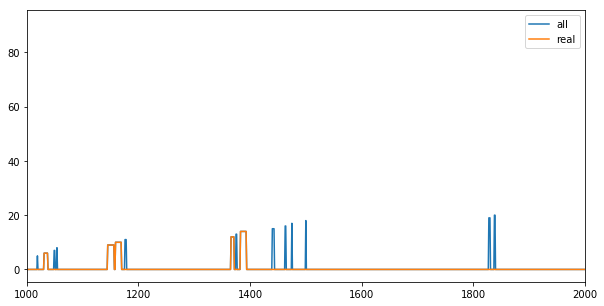

In [20]:
plot(l, label = 'all')
plot(labeled_array[0,0], label = 'real')
plt.legend();

plt.xlim(1000,2000)

In [87]:
def whereIs(array, ev_num):
    # Finds location of event <ev_num> in array
    return np.where(array == ev_num)[0]

In [86]:
def check(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array

In [85]:
def duration(array, num_events):
    # Takes in a time-series and implements the 5 day requirement for it.
    min_duration = 5
    for ev in range(1, num_events + 1):
        loc = whereIs(array, ev)
        if len(loc) < min_duration:
            array = check(array, loc)
    return array

    '''
       # Maybe make it recursive?? 
    
    duration(array, num_events, index)
    if index < num_events:
        loc = da.delayed(whereIs)(array, ev)
        array = da.delayed(check)(array, loc)
        da.delayed(duration)(array, num_events, index + 1)
    else:
        return array
    '''

In [199]:
checked[:,0,0]  = 0

In [266]:
labeled_array, num_features = da.array.apply_along_axis(ndimage.label, mhwSub.get_axis_num('time_counter'), mhwSub.data)
checked = (np.zeros_like(mhwSub)).astype('object')


for x in range(0, 50):
    for y in range(0, 50):
        checked[:,x,y] = da.delayed(duration, pure = True)(labeled_array[x,y], num_features[x,y], 0)


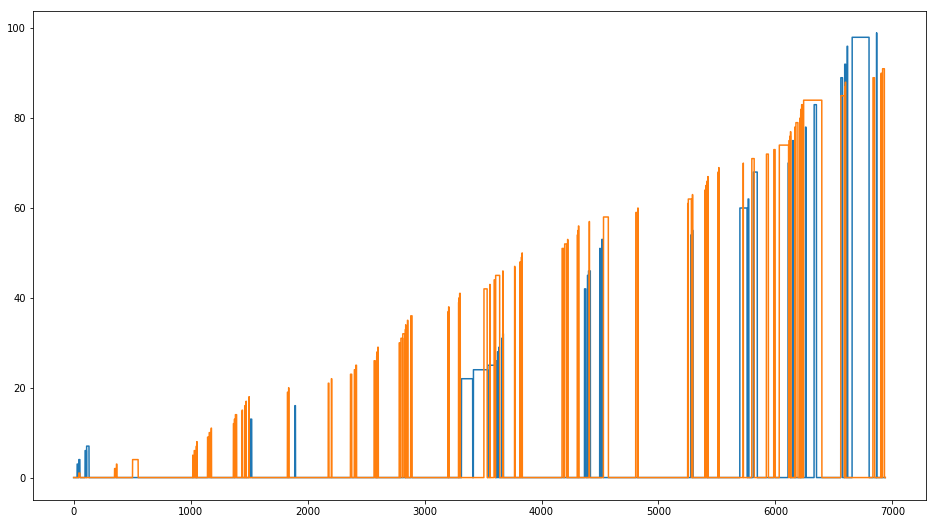

In [246]:
plot(a)
plot(labeled_array[0,0]);

In [124]:
'''
def check(length, min_duration):
    # Checks if length of event is greater than the min duration required
    return (length < min_duration)

def clear(array, loc):
    # Removes SST events in array at specified location loc
    array[loc] = 0
    return array
'''

In [149]:
np.where(calc[0,0] == num_features[0,0])

(array([6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926,
        6927, 6928, 6929, 6930, 6931]),)

In [171]:
# Sample for how the algorigthm will look. Problem is, we have to iterate i & j & num_events. Gonna look into 
# dask.delayed to try and loop through this.
new = []
i = 0; j = 0; num_events = num_features[i,j];
for ev in range(1, num_events):
    loc = da.delayed(whereIs)(calc[i,j], ev)
    new = da.delayed(check)(calc[i,j], loc)

In [147]:
num_features = num_features.astype('int')

In [361]:
%%time

'''
Currently: This algorithm finds events with duration less than 5, and sets the values to 0.
It has the capability to identify events that will occur two days later, but can't yet link them up. 
Additionally, there is no parralelisation capability - which is the whole point of this thing. Might be worht
looking at the percentile application to look into parralelisation.
'''


a = num_features
for i in range(1,num_features):
    loc = np.where(labeled_array == i)
    dur = loc[0][-1] - loc[0][0] + 1
    if dur < 5:
        a -= 1
        labeled_array[loc] = 0
    elif labeled_array[loc[0][-1] + 1, loc[1][-1], loc[2][-1]] != 0:
        print('Conection!')
        print(i)
        
print('Found', num_features - a, 'false events')

IndexError: index 6940 is out of bounds for axis 0 with size 6940

### Trying to spatially connect MHWs and then calculate the duration connected events.  
Currently links events that are spatially and/or temporally connected, but doesn't change original dataset.

In [19]:
%%time
mhwSub = mhwSub.chunk({'time_counter':10})
# Structure such that diagonal connections in both spatial and temporal dimensions are counted. 
struc = np.ones((3,3,3)) 
# This function finds strings of consecutive nonzero numbers. 
labeled_array, num_features = ndimage.label(mhwSub, struc)

CPU times: user 3.48 s, sys: 1.06 s, total: 4.54 s
Wall time: 3.58 s


In [45]:
num_features

3825

In [87]:
%%time
# Brute force approach. Looping through each of the labelled events, and calculating their duration
feat = num_features
for i in range(1, num_features):
    time = np.where(labeled_array == i)[0]
    dur = time[-1] - time[0] + 1
    if dur < 5:
        feat -= 1
        
print("# MHWs originally:", num_features, "\n # MHWs after duration constraint: ", feat)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [88]:
# Get the time record and broadcast its shape to be 3D using xarray.broadcast
time_record = xr.broadcast(mhwSub.isel(x=1,y=1),mhwSub.isel(x=1,y=1), mhwSub.isel(x=1,y=1))

In [181]:
 b

In [86]:
np.where(labeled_array == 11)
#print(len(I))
#print(I,J,K, sep = '\n')

(array([16, 16, 16, 16, 16]), array([7, 8, 8, 9, 9]), array([4, 4, 5, 4, 5]))

In [81]:
%%time
I, J, K = np.where(labeled_array == 9)

labeled_array[(I,J,K)] = 0
print(labeled_array[(I,J,K)])#.isel(time_counter = 2).plot()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
CPU times: user 100 ms, sys: 3 ms, total: 103 ms
Wall time: 95.2 ms


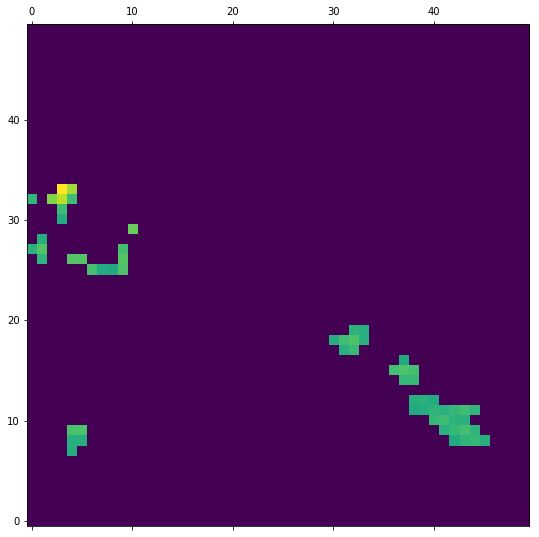

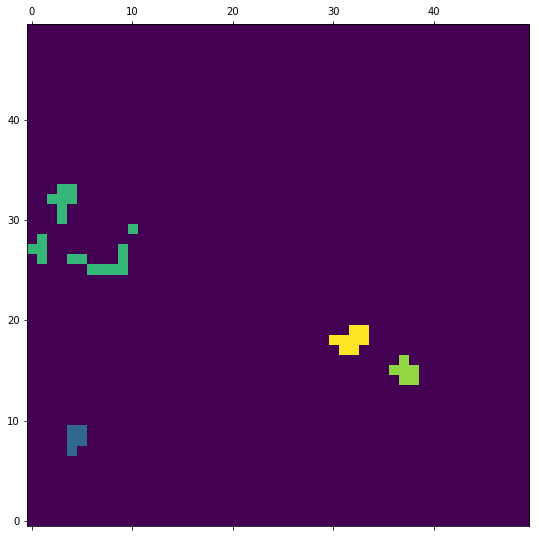

In [83]:
index = 14
matshow(mhwSub[index], origin = 'lower');
matshow(labeled_array[index],origin='lower');

In [230]:
maxs = ndimage.maximum(mhwSub.isel(x=0,y=0), labels = labeled_array[:,0,0], index=np.arange(1, num_features + 1))
mins = ndimage.minimum(mhwSub.isel(x=0,y=0), labels = labeled_array[:,0,0], index=np.arange(1, num_features + 1))

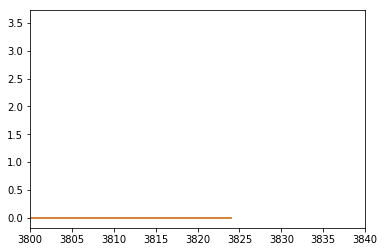

In [240]:
#mhwSub.isel(x=0,y=0).plot()
plot(maxs)
plot(mins)
xlim(3800,3840);

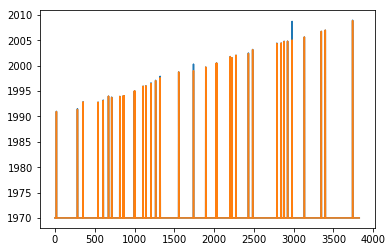

In [178]:
maxs = pd.to_datetime(maxs, unit = 'ns')
mins = pd.to_datetime(mins, unit = 'ns')
plot(maxs)
plot(mins)

In [163]:
dif = maxs - mins

In [165]:
dif

array([0, 0, 0, ..., 0, 0, 0])

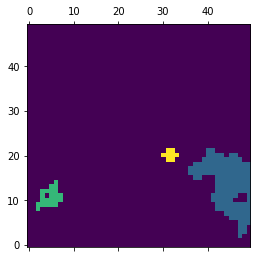

In [141]:
matshow(labeled_array[0], origin = 'lower');

In [129]:
index = 3824
print(maxs[index], mins[index])

1970-01-01T00:00:00.000000000 1970-01-01T00:00:00.000000000


In [103]:
shape(mins)

(3825,)

In [104]:
durations = maxs - mins

In [107]:
print('1', durations[2])

1 0.1604180833837654


#### First, we will try with a subset of the entire dataset.
This subset will focus on the past data.

In [306]:
# Creating subset:
# key: p = past, f = fast, c = clim, t = threshold 
pcSub = pClim.isel(x = slice(220,320),y = slice(50,150))
ptSub = pThresh.isel(x = slice(220,320),y = slice(50,150))
sstSub = sstPast.isel(x = slice(220,320),y = slice(50,150))

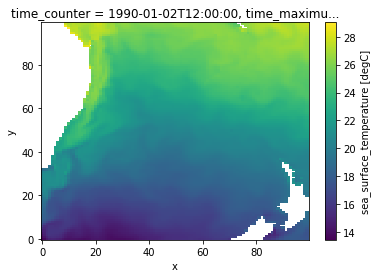

In [309]:
# Showing that we have taken a subset of the spacial dimension
sstSub.isel(time_counter = 1).plot();

In [15]:
pClim

<xarray.DataArray 'Mean Climatology for past NOW Run' (time_counter: 6940, y: 289, x: 431)>
[864439460 values with dtype=float32]
Coordinates:
    nav_lat          (y, x) float32 ...
    nav_lon          (y, x) float32 ...
    simulation       |S7 ...
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] ...
    time_minimum_1d  (time_counter) datetime64[ns] ...
Dimensions without coordinates: y, x

In [310]:
%%time
# Finding thresha and ssta
thresha = ptSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})
ssta = sstSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})

CPU times: user 4.87 s, sys: 668 ms, total: 5.53 s
Wall time: 5.03 s


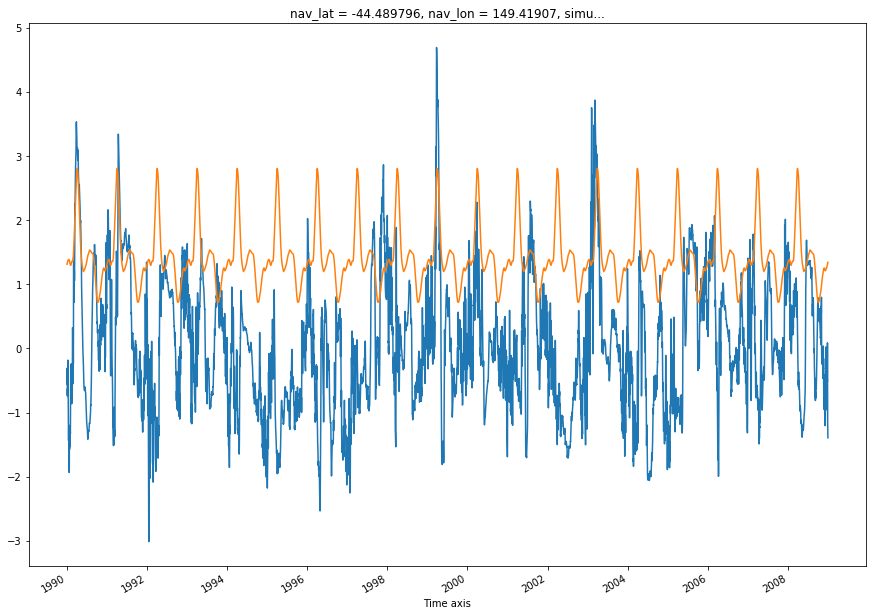

In [311]:
ssta.isel(x=1,y=2).plot(size = 10)
thresha.isel(x=1,y=2).plot();

In [394]:
%%time
#mhws = da.array.apply_along_axis(np.where, ssta.get_axis_num('time_counter'), ssta > thresha, ssta / thresha, 0)
#dif = ssta - thresha
mhws = xr.where(ssta > thresha, ssta/thresha, 0)

CPU times: user 4.74 s, sys: 765 ms, total: 5.51 s
Wall time: 4.88 s


This mhws array represents all the values for which the threshold is exceeded. MHWs have the additional stipulation that they must last for 5 or more days. The next part tries to follow what Oliver did to combat this problem

In [353]:
# Here we create the array structure that the label function will use
s = generate_binary_structure(2,2)
struc = np.array([s,s,s])
struc[1][1][1] = 0

In [431]:
struc

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True, False,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]])

In [314]:
%%time
# This function finds strings of consecutive nonzero numbers. 
labeled_array, num_features = label(mhws,struc)

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [383]:
num_features

6086

In [315]:
%%time
i = 0
for ev in range(1,num_features+1):
    event_duration = (labeled_array == ev).sum()
    if event_duration < 5:
        i += 1
        #print("Event " + str(ev) + " is a " + str(event_duration) + " day event ")
        labeled_array[np.where(labeled_array == ev)] = [0]
        
num_features -= i

In [316]:
marHw = xr.DataArray(labeled_array, coords = mhws.coords, dims = mhws.dims)

In [344]:
pcSub.isel(x=2, y = 60, time_counter= 1)

<xarray.DataArray 'Mean Climatology for past NOW Run' ()>
array(nan, dtype=float32)
Coordinates:
    nav_lat          float32 ...
    nav_lon          float32 ...
    simulation       |S7 ...
    time_counter     datetime64[ns] 1990-01-02T12:00:00
    time_maximum_1d  datetime64[ns] ...
    time_minimum_1d  datetime64[ns] ...

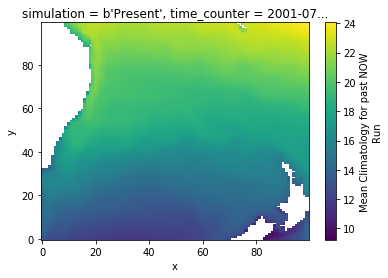

In [336]:
pcSub.isel(time_counter = 4225).plot();

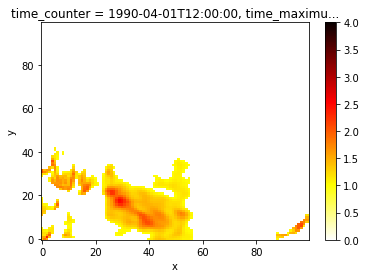

In [390]:
mhws.isel(time_counter = 90).plot(cmap = 'hot_r', vmin = 0, vmax = 4);

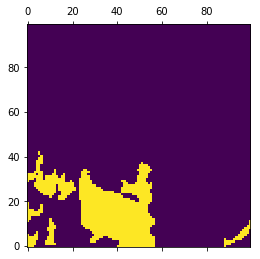

In [389]:
matshow(labeled_array[90], origin = 'lower')#.isel(time_counter = 1).plot(cmap = 'hot_r', vmin = 0, vmax = 4);